In [1]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode
from langchain_deepseek import ChatDeepSeek
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langchain_tavily import TavilySearch
from uuid import uuid4
import json

/home/proxi/anaconda3/envs/rag-weaviate/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

model = ChatDeepSeek(model="deepseek-chat", streaming=True)

In [3]:
search_tool = TavilySearch(
            max_results=4,
            topic="general",
            # include_answer=False,
            # include_raw_content=False,
            # include_images=False,
            # include_image_descriptions=False,
            # search_depth="basic",
            # time_range="day",
            # include_domains=None,
            # exclude_domains=None,
            # country=None
            # include_favicon=False
        )



In [4]:
tools = [search_tool]

memory = MemorySaver()

llm_with_tools = model.bind_tools(tools=tools)

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


In [6]:
async def agent(state: State) -> State:
    """Runs the model; it may emit tool calls."""
    ai_msg = await llm_with_tools.ainvoke(state["messages"])
    return {"messages": [ai_msg]}

def route(state: State):
    """If last AI message contains tool calls, go to ToolNode; else END."""
    last = state["messages"][-1]
    tool_calls = getattr(last, "tool_calls", None)
    if tool_calls:
        return "tools"
    return END

In [7]:
graph = StateGraph(State)

graph.add_node("agent", agent)
graph.add_node("tools", ToolNode(tools))  # <-- built-in executor for tool calls

graph.set_entry_point("agent")

# agent -> (conditional) -> tools or END
graph.add_conditional_edges("agent", route, {"tools": "tools", END: END})
# After tools run, go back to agent so the model can read tool outputs
graph.add_edge("tools", "agent")

app = graph.compile(checkpointer=memory)

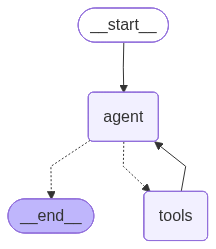

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [9]:
config = {
    "configurable": {
        "thread_id": 2
    }
}

response = await app.ainvoke({
    "messages": [HumanMessage(content="Get me the lastest news about the encounter issue at narmada canal?")]
}, config=config)

In [10]:
response

{'messages': [HumanMessage(content='Get me the lastest news about the encounter issue at narmada canal?', additional_kwargs={}, response_metadata={}, id='8f5eb647-01c5-4e74-89ac-eae9afe3d8eb'),
  AIMessage(content="I'll search for the latest news about the encounter issue at Narmada Canal for you.", additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_00_lqk1X1XSxthPKDa39GBIaLHG', 'function': {'arguments': '{"query": "encounter issue Narmada Canal latest news", "search_depth": "advanced", "time_range": "week", "topic": "news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_f253fc19d1_prod0820_fp8_kvcache'}, id='run--e4c4049f-bcc8-44a4-a931-d69928511732-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'encounter issue Narmada Canal latest news', 'search_depth': 'advanced', 'time_range': 'week', 'topic': 'news'}, 'id': 'call_00_lqk1X1XSxthPKDa39GBIaLHG', 'type':

In [11]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

async for event in app.astream_events({
    "messages": [HumanMessage(content="Write 100 word essay on Global Warming")],
}, config=config, version="v2"):

    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Write 100 word essay on Global Warming', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'e5ef26fc-d25a-41cb-9f1c-58a2667de933', 'metadata': {'thread_id': 5}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Write 100 word essay on Global Warming', additional_kwargs={}, response_metadata={}, id='467f69cb-020f-4d3b-b530-867b749c22b8')]}}, 'name': 'agent', 'tags': ['graph:step:1'], 'run_id': 'a3e8d764-caa0-4bbd-a8b9-c0bf66c0e167', 'metadata': {'thread_id': 5, 'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:d5486397-28a0-ef74-8dde-4d01872a4762'}, 'parent_ids': ['e5ef26fc-d25a-41cb-9f1c-58a2667de933']}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Write 100 wo